# Implementing a Neural Network (Two-layer net)

In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [0]:
cd/content

/content


In [0]:
!ls

google-colab-cs231n  sample_data


In [0]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

fatal: destination path 'google-colab-cs231n' already exists and is not an empty directory.


In [0]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [0]:
!pip install imageio

In [0]:
%cd cs231n/datasets/
!ls

/content/google-colab-cs231n/assignment1/cs231n/datasets
cifar-10-batches-py  get_datasets.sh


In [0]:
!more get_datasets.sh

# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 


In [0]:
!./get_datasets.sh

--2019-07-23 10:22:11--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  31.4MB/s    in 5.8s    

2019-07-23 10:22:17 (28.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


In [0]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Define function for inspecting the source code of a function
import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter

def pretty_print(func):
  source_code = inspect.getsourcelines(func)[0]
  for line in source_code:
    print(highlight(line.strip('\n'), PythonLexer(), Terminal256Formatter()), end='')
  print('')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


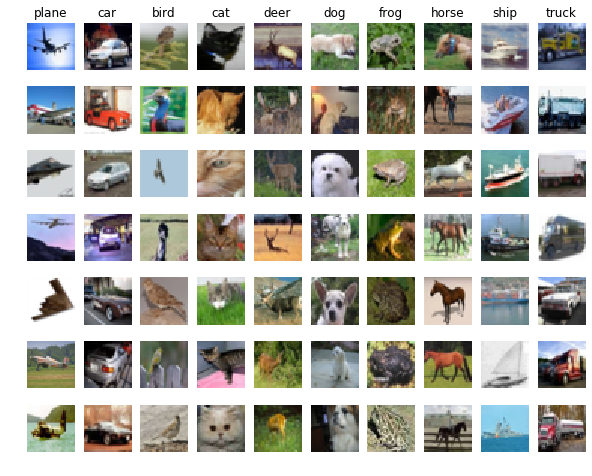

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [0]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


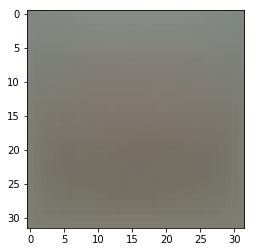

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [0]:
# Preprocessing: subtract the mean image for normalization
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## BuildingTwo-layer Neural Netowork

In [0]:
def softmax_stable(Z):
  # Compute softmax values for each sets of scores in Z
  # Each row of Z is a set of scores
  e_Z = np.exp(Z - np.max(Z, axis = 1, keepdims = True))
  A = e_Z / e_Z.sum(axis = 1, keepdims = True)
  return A

In [0]:
def crossentropy_loss(Yhat, y):
  """
  Yhat: a numpy array of shape (Npoints, nClasses) -- predicted output
  y: a numpy array of shape (Npoints) -- ground truth.
  NOTE: We don’t need to use the one-hot vector here since most of elements
  are zeros. When programming in numpy, in each row of Yhat, we need to access
  to the corresponding index only.
  """
  id0 = range(Yhat.shape[0]) #(Npoints,)
  return -np.mean(np.log(Yhat[id0, y]))

In [0]:
def mlp_init(d0, d1, d2):
  """
  Initialize W1, b1, W2, b2
  d0: dimension of input data
  d1: number of hidden unit
  d2: number of output unit = number of classes
  """
  W1 = 0.01*np.random.randn(d0, d1)
  b1 = np.zeros(d1)
  W2 = 0.01*np.random.randn(d1, d2)
  b2 = np.zeros(d2)
  return (W1, b1, W2, b2)

In [0]:
def mlp_fit(X, y, W1, b1, W2, b2, eta):
  loss_history = []
  for i in range(20000): # number of epoches
    
    #feedforward
    Z1 = X.dot(W1) + b1       # shape (N, d1)
    A1 = np.maximum(Z1, 0)    # shape (N, d1)
    Z2 = A1.dot(W2) + b2      # shape (N, d2)
    Yhat = softmax_stable(Z2) # shape (N, d2)
    if i % 1000 == 0: # print loss after each 1000 iterations
      loss = crossentropy_loss(Yhat, y)
      print(" iter {}, loss: {}".format(i, loss))
      loss_history.append(loss)
      
    #backproagation
    id0 = range(Yhat.shape[0])
    Yhat[id0, y] -= 1
    E2 = Yhat/X.shape[0]       # shape (N, d2)
    dW2 = np.dot(A1.T, E2)     # shape (d1, d2)
    db2 = np.sum(E2, axis = 0) # shape (d2,)
    E1 = np.dot(E2, W2.T)      # shape (N, d1)
    E1[Z1 <= 0] = 0            # gradient of ReLU, shape (N, d1)
    dW1 = np.dot(X.T, E1)      # shape (d0, d1)
    db1 = np.sum(E1, axis = 0) # shape (d1, )
    
    # Gradient Descent update
    W1 += -eta*dW1
    b1 += -eta*db1
    W2 += -eta*dW2
    b2 += -eta*db2
  return (W1, b1, W2, b2, loss_history)

In [0]:
# get dimension of multilayer neural network
d0 = 3073           # data dimension
d1 = h = 100        # number of hidden units
d2 = C = 10         # number of classes
eta = 0.001             # learning rate

In [0]:
# Initalization of model parameters with random values
(W1, b1, W2, b2) = mlp_init(d0, d1, d2)

# Train neural network
(W1, b1, W2, b2, loss_history) = mlp_fit(X_dev, y_dev, W1, b1, W2, b2, eta)

 iter 0, loss: 3.9373144882874596
 iter 1000, loss: 0.005301202811703213
 iter 2000, loss: 0.0022137222308752634
 iter 3000, loss: 0.0013555377269684895
 iter 4000, loss: 0.0009633252054548289
 iter 5000, loss: 0.0007412886858397354
 iter 6000, loss: 0.000599369827071061
 iter 7000, loss: 0.000501342140301563
 iter 8000, loss: 0.0004298001247436249
 iter 9000, loss: 0.0003754184396626208
 iter 10000, loss: 0.0003327369885270531
 iter 11000, loss: 0.0002983856857286777
 iter 12000, loss: 0.00027017521886743556
 iter 13000, loss: 0.0002466302106832341
 iter 14000, loss: 0.00022669905779984596
 iter 15000, loss: 0.00020961669552675995
 iter 16000, loss: 0.0001948250416624273
 iter 17000, loss: 0.00018190614280357963
 iter 18000, loss: 0.00017052618851991493
 iter 19000, loss: 0.00016043003452037357


## Building predict function and Estimating the accuracy

In [0]:
def mlp_predict(X, W1, b1, W2, b2):
  """
  Suppose that the network has been trained, predict class of new points.
  X: data matrix, each ROW is one data point.
  W1, b1, W2, b2: learned weight matrices and biases
  """
  Z1 = X.dot(W1) + b1    # shape (N, d1)
  # The activation function here is ReLU function f(z) = max(0, z)
  A1 = np.maximum(Z1, 0) # shape (N, d1) 
  Z2 = A1.dot(W2) + b2   # shape (N, d2)
  return np.argmax(Z2, axis = 1)

def evaluate (X, y, W1, b1, W2, b2):
  y_pred = mlp_predict(X, W1, b1, W2, b2)
  acc = 100*np.mean(y_pred==y) #counting the number of True value over the total data points
  return acc

In [0]:
acc = evaluate(X_test, y_test, W1, b1, W2, b2)
print("Accuracy on test data = {} %".format(acc))

Accuracy on test data = 26.900000000000002 %
